Validation for different techniques :

1. Threshold on the phase_crswir 

2. GMM on ... 

In [20]:
# Loading data

import os
import numpy as np
import pandas as pd
import rasterio
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from utils import load_folder, calculate_slope_with_dates
from sklearn.impute import SimpleImputer

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

# Define the genus mapping

phen_mapping = {1: 'deciduous', 2: 'evergreen'}

def save_results_as_tif(output_path: str, data: np.ndarray, reference_path: str):
    """Save clustering results as a .tif file."""
    rgb_path = os.path.join(reference_path, 'rgb')
    rgb_file = [f for f in os.listdir(rgb_path) if f.endswith('.tif')][0]
    rgb_path = os.path.join(rgb_path, rgb_file)
    with rasterio.open(rgb_path) as src:
        meta = src.meta.copy()
        meta.update(dtype=rasterio.uint8, count=1)

        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(data.astype(rasterio.uint8), 1)

def load_data_from_tile(path: str) -> tuple:
    """Load and preprocess data from a tile.

    Args:
        path (str): Path to the tile directory.

    Returns:
        tuple: Tuple containing preprocessed features, weights, forest mask, reference path, and tile shape.
    """
    dates = [datetime.strptime(filename.split('_')[0], '%Y-%m-%d') for filename in os.listdir(os.path.join(path, 'rgb'))]
    dates.sort()
    rgb = load_folder(os.path.join(path, 'rgb'))
    chm = rasterio.open(os.path.join(path, 'tree_map', 'CHM2020.tif')).read(1)
    forest_mask = (chm > 250).astype(bool)
    slope_map = calculate_slope_with_dates(rgb[:, 0], dates, len(rgb[:, 0]) / 2, len(rgb[:, 0])) / 100
    weights = (1 - abs(slope_map.ravel())).clip(0, 1)

    path_features = os.path.join(path, 'features')
    r_APO = rasterio.open(os.path.join(path_features, 'r_APO.tif')).read()
    amplitude_map_r, phase_map_r, offset_map_r = r_APO[0], r_APO[1], r_APO[2]
    crswir_APO = rasterio.open(os.path.join(path_features, 'crswir_APO.tif')).read()
    amplitude_map_crswir, phase_map_crswir, offset_map_crswir = crswir_APO[0], crswir_APO[1], crswir_APO[2]
    rcc_APO = rasterio.open(os.path.join(path_features, 'rcc_APO.tif')).read()
    amplitude_map_rcc, phase_map_rcc, offset_map_rcc = rcc_APO[0], rcc_APO[1], rcc_APO[2]
    dem = rasterio.open(os.path.join(path_features, 'elevation_aspect.tif')).read()
    elevation, aspect = dem[0], dem[1]

    features = {
        'amplitude_red': amplitude_map_r.ravel(),
        'phase_red': phase_map_r.ravel(),
        'offset_red': offset_map_r.ravel(),
        'amplitude_crswir': amplitude_map_crswir.ravel(),
        'phase_crswir': phase_map_crswir.ravel(),
        'offset_crswir': offset_map_crswir.ravel(),
        'amplitude_rcc': amplitude_map_rcc.ravel(),
        'phase_rcc': phase_map_rcc.ravel(),
        'offset_rcc': offset_map_rcc.ravel(),
        'elevation': elevation.ravel(),
        'aspect': aspect.ravel()
    }

    filtered_features = {k: v[forest_mask.ravel()] for k, v in features.items()}
    filtered_weights = weights[forest_mask.ravel()]

    # Load reference data
    path_reference = os.path.join(path, 'reference_species')
    tif = [x for x in os.listdir(path_reference) if x.endswith('.tif')]
    reference = rasterio.open(os.path.join(path_reference, tif[0])).read()
    genus = reference[1]
    phen = reference[2]  # Assuming phenology data is stored in the third band
    filtered_genus = genus[forest_mask]
    filtered_phen = phen[forest_mask]

    filtered_features['genus'] = filtered_genus
    filtered_features['phen'] = filtered_phen

    return filtered_features, filtered_weights, forest_mask, chm.shape

def load_data(directory: str) -> tuple:
    """Load and preprocess data from all tiles in the directory.

    Args:
        directory (str): Path to the directory containing tile subdirectories.

    Returns:
        tuple: Tuple containing all features, weights, masks, shapes, and paths for each tile.
    """
    all_features = []
    all_weights = []
    all_ref = []
    tile_shapes = []

    for folder in tqdm(os.listdir(directory)):
        path = os.path.join(directory, folder)
        if folder.endswith('training') or folder.__contains__('.DS_Store') or folder.__contains__('.txt'):
            continue
        try:
            filtered_features, filtered_weights, forest_mask, tile_shape = load_data_from_tile(path)
            all_features.append(pd.DataFrame(filtered_features))
            all_weights.append(filtered_weights)
            all_ref.append(filtered_features['phen'])
            tile_shapes.append((path, forest_mask, tile_shape))
        except Exception as e:
            print(f"Error processing {folder}: {e}")
            continue

    # Stack all features, weights, and references
    all_features_stacked = pd.concat(all_features, ignore_index=True)
    all_weights_stacked = np.concatenate(all_weights)
    all_ref_stacked = np.concatenate(all_ref)

    return all_features_stacked, all_weights_stacked, all_ref_stacked, tile_shapes

# Load data
print("Loading data...")
data_dir = '/Users/arthurcalvi/Data/species/validation/tiles'
all_features_stacked, all_weights_stacked, all_ref_stacked, tile_shapes = load_data(data_dir)

# Preprocess data
features = ['amplitude_red', 'phase_red', 'offset_red', 'amplitude_crswir', 'phase_crswir', 'offset_crswir', 'amplitude_rcc', 'phase_rcc', 'offset_rcc', 'elevation', 'aspect']
X = all_features_stacked[features]
y_phen = all_features_stacked['phen']

# Replace infinite values with NaNs
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle NaNs by imputing with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Update X with imputed values
X = pd.DataFrame(X_imputed, columns=X.columns)

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Loading data...


  0%|          | 0/80 [00:00<?, ?it/s]

 70%|███████   | 56/80 [00:18<00:07,  3.25it/s]

Error processing tile_61_20200102_20241230_Préalpes_du_Nord_validation: /Users/arthurcalvi/Data/species/validation/tiles/tile_61_20200102_20241230_Préalpes_du_Nord_validation/features/r_APO.tif: No such file or directory


100%|██████████| 80/80 [00:26<00:00,  3.07it/s]


In [3]:
def save_results_as_tif(output_path: str, data: np.ndarray, reference_path: str):
    """Save clustering results as a .tif file."""
    rgb_path = os.path.join(reference_path, 'rgb')
    rgb_file = [f for f in os.listdir(rgb_path) if f.endswith('.tif')][0]
    rgb_path = os.path.join(rgb_path, rgb_file)
    with rasterio.open(rgb_path) as src:
        meta = src.meta.copy()
        meta.update(dtype=rasterio.uint8, count=1)

        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(data.astype(rasterio.uint8), 1)

# 1. Threshold on the phase_crswir

## Simple Thresholding

Using threshold: 0.96 for feature: phase_crswir
Overall Accuracy: 0.8253482361312914
Cohen's Kappa: 0.6281183885696624
TP: 0.5433580825108425
FP: 0.1309151553053992
FN: 0.043736608563309465
TN: 0.2819901536204489


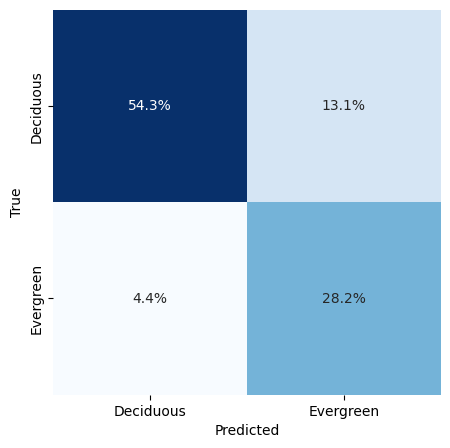

Writing features for each tile...


100%|██████████| 35/35 [00:00<00:00, 69.90it/s]


In [22]:
import os
import numpy as np
import pandas as pd
import rasterio
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import load_folder, calculate_slope_with_dates
from sklearn.impute import SimpleImputer

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

# Define the genus mapping
phen_mapping = {1: 'deciduous', 2: 'evergreen'}

# Define thresholding 
feature = 'phase_crswir'
threshold = 0.96
print(f"Using threshold: {threshold} for feature: {feature}")

#asign the phenology predidction 2 if feature is greater than the threshold
phen_predictions = np.where(X[feature] > threshold, 2, 1)

mask_valid = (all_ref_stacked != 0)

#compute oa, kappa, and confusion matrix on where the mask is valid
oa = accuracy_score(all_ref_stacked[mask_valid], phen_predictions[mask_valid])
kappa = cohen_kappa_score(all_ref_stacked[mask_valid], phen_predictions[mask_valid])
conf_matrix = confusion_matrix(all_ref_stacked[mask_valid], phen_predictions[mask_valid])
conf_matrix = conf_matrix / conf_matrix.sum() 

print(f"Overall Accuracy: {oa}")
print(f"Cohen's Kappa: {kappa}")
print(f"TP: {conf_matrix[0, 0]}")
print(f"FP: {conf_matrix[0, 1]}")
print(f"FN: {conf_matrix[1, 0]}")
print(f"TN: {conf_matrix[1, 1]}")

#save results in a json 
os.makedirs('results', exist_ok=True)
results = {
    'experience': f'1-phenology_thresholding_feature-{feature}_threshold-{threshold}',
    'feature': feature,
    'threshold': threshold,
    'overall_accuracy': oa,
    'kappa': kappa,
    'tp': conf_matrix[0, 0],
    'fp': conf_matrix[0, 1],
    'fn': conf_matrix[1, 0],
    'tn': conf_matrix[1, 1]
}
results_path = os.path.join('results', f"results_feature-{feature}_threshold-{threshold}.json")
pd.Series(results).to_json(results_path)

# plot confusion matrix in a clean and lean way in percentage with seaborn
import seaborn as sns


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='.1%', cmap='Blues', cbar=False, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticklabels(['Deciduous', 'Evergreen'])
ax.set_yticklabels(['Deciduous', 'Evergreen'])
plt.show()

os.makedirs('images', exist_ok=True)
fig.savefig(f'images/confusion_matrix_feature-{feature}_threhsold-{threshold}.png', dpi=300)

#writing features 
print("Writing features for each tile...")
cluster_maps = []
index = 0
for path, forest_mask, tile_shape in tqdm(tile_shapes):
    cluster_map = np.full(tile_shape, 0)
    n_points = forest_mask.ravel().sum()
    cluster_map.ravel()[forest_mask.ravel()] = phen_predictions[index:index + n_points]
    index += n_points
    cluster_maps.append((path, cluster_map))

    # Save results for each tile
    result_dir = os.path.join(path, 'results')
    os.makedirs(result_dir, exist_ok=True)
    output_path = os.path.join(result_dir, f"feature-{feature}_threshold-{threshold}.tif")
    save_results_as_tif(output_path, cluster_map, path)


## Kmeans with 2 clusters and then thresholding

Running feature subset selection and clustering...


  0%|          | 0/11 [00:00<?, ?it/s]

Overall Accuracy: 0.8201303759711975
Cohen's Kappa: 0.6202500751112223
TP: 0.5349975940476582
FP: 0.13927564376858342
FN: 0.04059398026021903
TN: 0.2851327819235393
Writing features for each tile...


  9%|▉         | 1/11 [00:32<05:24, 32.48s/it]

Overall Accuracy: 0.8127385380273698
Cohen's Kappa: 0.6078993319110698
TP: 0.5256606180868055
FP: 0.14861261972943615
FN: 0.038648842243193975
TN: 0.28707791994056436
Writing features for each tile...


 18%|█▊        | 2/11 [01:03<04:43, 31.47s/it]

Overall Accuracy: 0.8041648837541007
Cohen's Kappa: 0.5946333825015523
TP: 0.5134537406681181
FP: 0.1608194971481236
FN: 0.03501561909777571
TN: 0.2907111430859826
Writing features for each tile...


 27%|██▋       | 3/11 [01:33<04:06, 30.81s/it]

Overall Accuracy: 0.6742732378162417
Cohen's Kappa: 0.0
TP: 0.6742732378162417
FP: 0.0
FN: 0.32572676218375834
TN: 0.0
Writing features for each tile...


 36%|███▋      | 4/11 [02:02<03:32, 30.31s/it]

Overall Accuracy: 0.6742732378162417
Cohen's Kappa: 0.0
TP: 0.6742732378162417
FP: 0.0
FN: 0.32572676218375834
TN: 0.0
Writing features for each tile...


 45%|████▌     | 5/11 [02:31<02:58, 29.72s/it]

Overall Accuracy: 0.6742732378162417
Cohen's Kappa: 0.0
TP: 0.6742732378162417
FP: 0.0
FN: 0.32572676218375834
TN: 0.0
Writing features for each tile...


 55%|█████▍    | 6/11 [02:57<02:22, 28.59s/it]

Overall Accuracy: 0.6093658160410407
Cohen's Kappa: 0.29779907433519404
TP: 0.311055938783795
FP: 0.36321729903244665
FN: 0.027416884926512654
TN: 0.29830987725724567
Writing features for each tile...


 64%|██████▎   | 7/11 [03:22<01:48, 27.16s/it]

Overall Accuracy: 0.6742732378162417
Cohen's Kappa: 0.0
TP: 0.6742732378162417
FP: 0.0
FN: 0.32572676218375834
TN: 0.0
Writing features for each tile...


 73%|███████▎  | 8/11 [03:41<01:14, 24.73s/it]

Overall Accuracy: 0.764534851826251
Cohen's Kappa: 0.5332426853362818
TP: 0.46299143731749637
FP: 0.2112818004987453
FN: 0.024183347675003644
TN: 0.3015434145087547
Writing features for each tile...


 82%|████████▏ | 9/11 [03:58<00:44, 22.29s/it]

Overall Accuracy: 0.6742732378162417
Cohen's Kappa: 0.0
TP: 0.6742732378162417
FP: 0.0
FN: 0.32572676218375834
TN: 0.0
Writing features for each tile...


 91%|█████████ | 10/11 [04:11<00:19, 19.50s/it]

Overall Accuracy: 0.7394612234150103
Cohen's Kappa: 0.4911232340564754
TP: 0.4396701572568068
FP: 0.23460308055943485
FN: 0.02593569602555482
TN: 0.2997910661582035
Writing features for each tile...


100%|██████████| 11/11 [04:19<00:00, 23.63s/it]


Optimal Feature Subset: ['phase_crswir']
Maximum Overall Accuracy: 0.8201303759711975


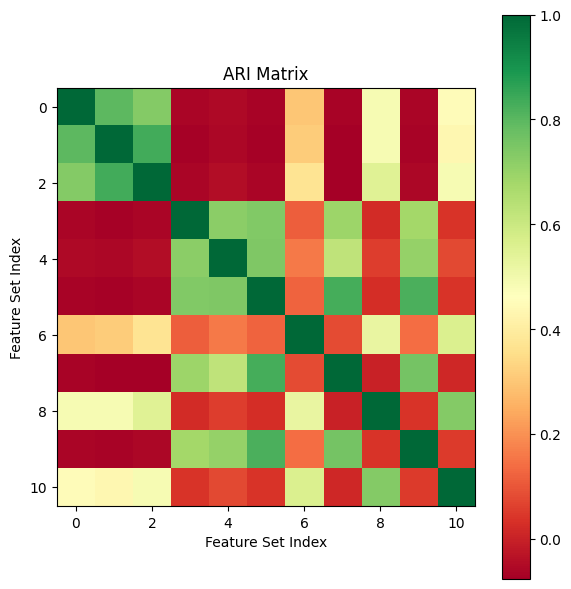

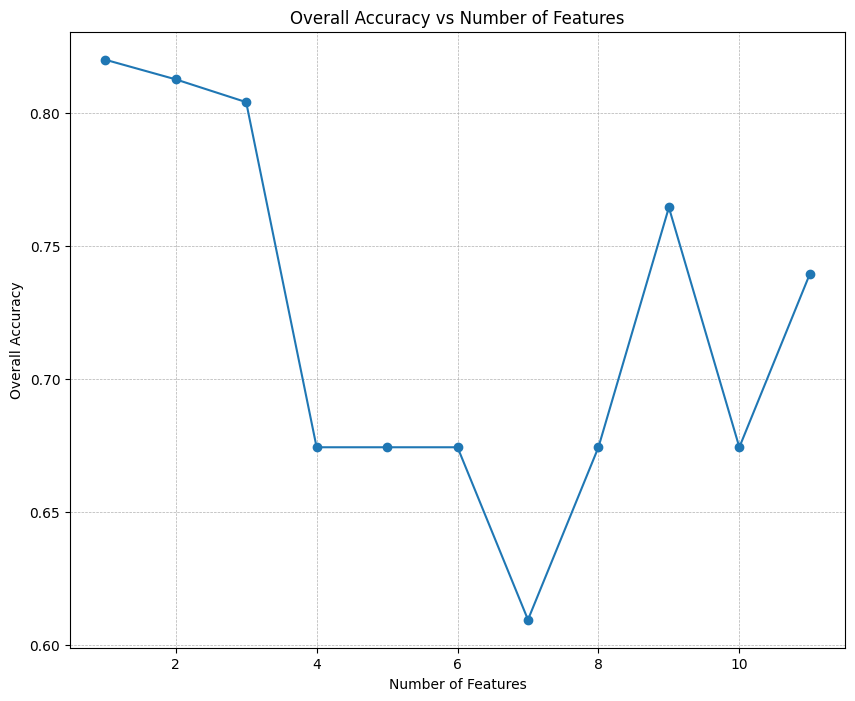

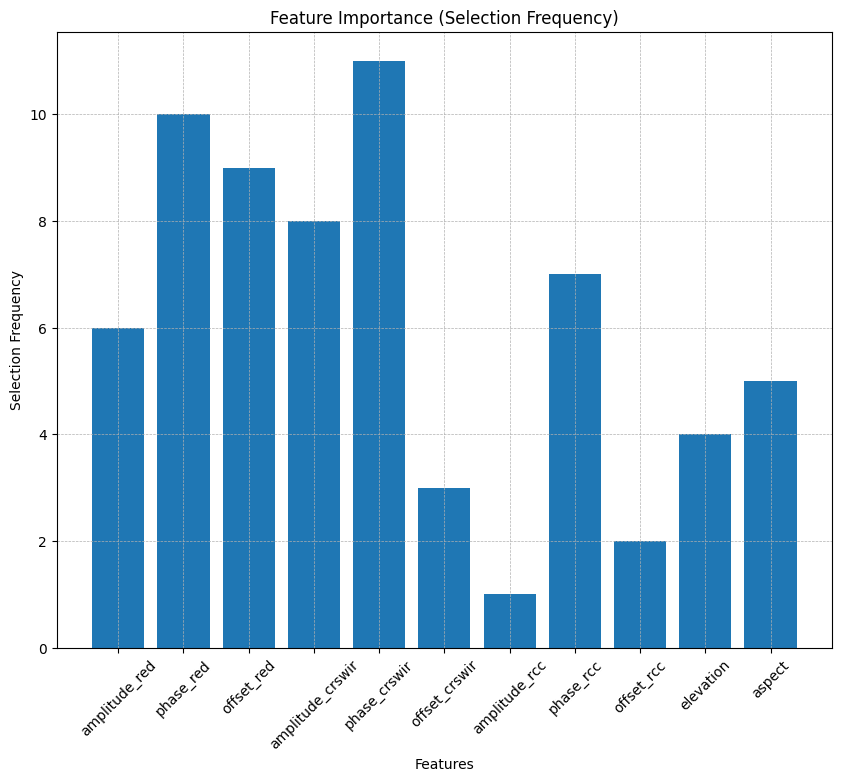

Feature selection completed and optimal feature subset selected.


In [26]:
import os
import numpy as np
import pandas as pd
import rasterio
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import load_folder, calculate_slope_with_dates
from sklearn.impute import SimpleImputer

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

# Define the genus mapping
phen_mapping = {1: 'deciduous', 2: 'evergreen'}

# Define feature subset selection using RFE
def select_features(X, y, num_features):
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=num_features)
    fit = rfe.fit(X, y)
    selected_features = [features[i] for i in range(len(features)) if fit.support_[i]]
    return selected_features

# Classify clusters based on the average phase_crswir value
def classify_clusters(X: np.ndarray, clusters: np.ndarray, threshold: float = 0.96) -> np.ndarray:
    cluster_labels = np.zeros(clusters.shape)
    for cluster in np.unique(clusters):
        cluster_mask = clusters == cluster
        mean_phase_crswir = np.mean(X[cluster_mask])
        cluster_labels[cluster_mask] = 2 if mean_phase_crswir > threshold else 1
    return cluster_labels

# Placeholder for optimal feature subset and evaluation metric
optimal_feature_subset = None
max_accuracy = float('-inf')
all_clusters = []

print("Running feature subset selection and clustering...")
# Feature subset selection and clustering
list_accuracy_scores = []
list_subset_features = []
for num_features in tqdm(range(1, len(features) + 1)):
    selected_features = select_features(X_scaled, y_phen, num_features)
    X_subset = X_scaled[:, [features.index(f) for f in selected_features]]

    # Run MiniBatchKMeans clustering
    minibatch_kmeans = MiniBatchKMeans(n_clusters=2, random_state=42)
    clusters = minibatch_kmeans.fit_predict(X_subset, sample_weight=all_weights_stacked)
    all_clusters.append(clusters)

    # Classify clusters using the average phase_crswir value
    phen_predictions = classify_clusters(X['phase_crswir'], clusters)

    # Evaluate using overall accuracy
    valid_mask = (y_phen != 0)
    oa = accuracy_score(all_ref_stacked[mask_valid], phen_predictions[mask_valid])
    kappa = cohen_kappa_score(all_ref_stacked[mask_valid], phen_predictions[mask_valid])
    conf_matrix = confusion_matrix(all_ref_stacked[mask_valid], phen_predictions[mask_valid])
    conf_matrix = conf_matrix / conf_matrix.sum() 
    list_accuracy_scores.append(oa)
    list_subset_features.append(selected_features)
    if oa > max_accuracy:
        max_accuracy = oa
        optimal_feature_subset = selected_features

    # Save results
    results = {
        'experience': f'1-phenology_thresholding_cluster-k2_features_selection-{selected_features}_num_features-{num_features}',
        'feature_selection': 'RFE',
        'features': selected_features,
        'num_features': num_features,
        'clusterinfo': '2-means',
        'feature': 'phase_crswir',
        'threshold': threshold,
        'overall_accuracy': oa,
        'kappa': kappa,
        'tp': conf_matrix[0, 0],
        'fp': conf_matrix[0, 1],
        'fn': conf_matrix[1, 0],
        'tn': conf_matrix[1, 1]
    }
    results_path = os.path.join('results', f"results_features_selection-{selected_features}_num_features-{num_features}.json")
    pd.Series(results).to_json(results_path)
    print(f"Overall Accuracy: {oa}")
    print(f"Cohen's Kappa: {kappa}")
    print(f"TP: {conf_matrix[0, 0]}")
    print(f"FP: {conf_matrix[0, 1]}")
    print(f"FN: {conf_matrix[1, 0]}")
    print(f"TN: {conf_matrix[1, 1]}")

    #writing features 
    print("Writing features for each tile...")
    cluster_maps = []
    index = 0
    for path, forest_mask, tile_shape in tqdm(tile_shapes):
        cluster_map = np.full(tile_shape, 0)
        n_points = forest_mask.ravel().sum()
        cluster_map.ravel()[forest_mask.ravel()] = phen_predictions[index:index + n_points]
        index += n_points
        cluster_maps.append((path, cluster_map))

        # Save results for each tile
        result_dir = os.path.join(path, 'results')
        os.makedirs(result_dir, exist_ok=True)
        output_path = os.path.join(result_dir, f"{'_'.join(selected_features)}_k2.tif")
        save_results_as_tif(output_path, cluster_map, path)

# Compute ARI matrix 
num_feature_sets = len(all_clusters)
ari_matrix = np.zeros((num_feature_sets, num_feature_sets))

for i in range(num_feature_sets):
    for j in range(num_feature_sets):
        ari_matrix[i, j] = adjusted_rand_score(all_clusters[i], all_clusters[j])


print(f"Optimal Feature Subset: {optimal_feature_subset}")
print(f"Maximum Overall Accuracy: {max_accuracy}")

# Visualization of ARI matrix
plt.figure(figsize=(6, 6))
plt.imshow(ari_matrix, cmap='RdYlGn', interpolation='nearest')
plt.title('ARI Matrix')
plt.colorbar()
plt.xlabel('Feature Set Index')
plt.ylabel('Feature Set Index')
plt.tight_layout()
plt.show()

# Visualization of Overall Accuracy vs Number of Features
plt.figure(figsize=(10, 8))
plt.plot(range(1, len(features) + 1), list_accuracy_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Overall Accuracy')
plt.title('Overall Accuracy vs Number of Features')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Visualization of Feature Importance
feature_importance = np.zeros(len(features))
for selected_features in list_subset_features:
    for feature in selected_features:
        feature_importance[features.index(feature)] += 1

plt.figure(figsize=(10, 8))
plt.bar(features, feature_importance)
plt.xlabel('Features')
plt.ylabel('Selection Frequency')
plt.title('Feature Importance (Selection Frequency)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

print("Feature selection completed and optimal feature subset selected.")
